# API

Application Programming Interface

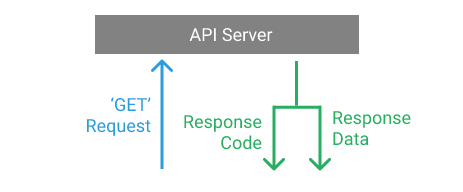

### Example

API of International space station (ISS).

There are three endpoints to obtain info related to:

 - Current crew members
 - Current location
 - Location predictions

In [1]:
import requests

url = "http://api.open-notify.org/astros.json"  # endpoints
response = requests.get(url)
print(response)

<Response [200]>


In [2]:
print(response.text)

{"message": "success", "number": 10, "people": [{"craft": "ISS", "name": "Sergey Ryzhikov"}, {"craft": "ISS", "name": "Kate Rubins"}, {"craft": "ISS", "name": "Sergey Kud-Sverchkov"}, {"craft": "ISS", "name": "Mike Hopkins"}, {"craft": "ISS", "name": "Victor Glover"}, {"craft": "ISS", "name": "Shannon Walker"}, {"craft": "ISS", "name": "Soichi Noguchi"}, {"craft": "ISS", "name": "Mark Vande Hei"}, {"craft": "ISS", "name": "Oleg Novitskiy"}, {"craft": "ISS", "name": "Pyotr Dubrov"}]}


In [3]:
data = response.json()
data

{'message': 'success',
 'number': 10,
 'people': [{'craft': 'ISS', 'name': 'Sergey Ryzhikov'},
  {'craft': 'ISS', 'name': 'Kate Rubins'},
  {'craft': 'ISS', 'name': 'Sergey Kud-Sverchkov'},
  {'craft': 'ISS', 'name': 'Mike Hopkins'},
  {'craft': 'ISS', 'name': 'Victor Glover'},
  {'craft': 'ISS', 'name': 'Shannon Walker'},
  {'craft': 'ISS', 'name': 'Soichi Noguchi'},
  {'craft': 'ISS', 'name': 'Mark Vande Hei'},
  {'craft': 'ISS', 'name': 'Oleg Novitskiy'},
  {'craft': 'ISS', 'name': 'Pyotr Dubrov'}]}

## JSON

JavaScript Object Notation

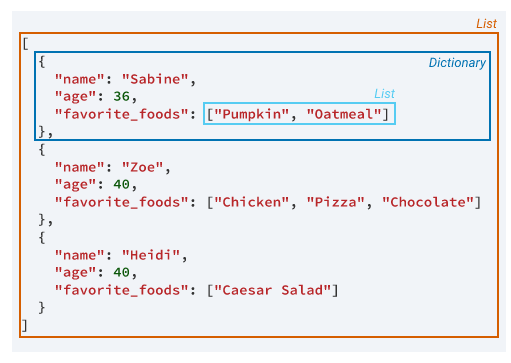

In [4]:
data.keys()

dict_keys(['message', 'number', 'people'])

In [5]:
print(type(data['people']))
print(data['people'])

<class 'list'>
[{'craft': 'ISS', 'name': 'Sergey Ryzhikov'}, {'craft': 'ISS', 'name': 'Kate Rubins'}, {'craft': 'ISS', 'name': 'Sergey Kud-Sverchkov'}, {'craft': 'ISS', 'name': 'Mike Hopkins'}, {'craft': 'ISS', 'name': 'Victor Glover'}, {'craft': 'ISS', 'name': 'Shannon Walker'}, {'craft': 'ISS', 'name': 'Soichi Noguchi'}, {'craft': 'ISS', 'name': 'Mark Vande Hei'}, {'craft': 'ISS', 'name': 'Oleg Novitskiy'}, {'craft': 'ISS', 'name': 'Pyotr Dubrov'}]


### Location of ISS

Plot it in a map using `geopandas`.

In [6]:
import time  # Built-in
import geopandas as gpd  # pip install gpd
import matplotlib.pyplot as plt  # pip install matplotlib

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

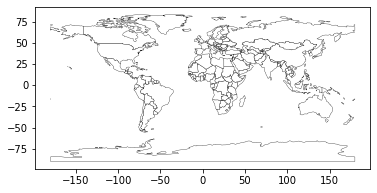

In [8]:
ax = world.plot(facecolor='white', edgecolor="black", linewidth=0.3)

In [9]:
url = "http://api.open-notify.org/iss-now.json"  # endpoint
r = requests.get(url)

r.json()

{'timestamp': 1618589809,
 'iss_position': {'latitude': '48.2595', 'longitude': '-99.7146'},
 'message': 'success'}

In [10]:
# Read the timestamp in a human date
from datetime import datetime  # Built-in

datetime.fromtimestamp(1618585386)

datetime.datetime(2021, 4, 16, 10, 3, 6)

In [11]:
d = datetime.fromtimestamp(1618585386)
d.strftime(format='%H:%m:%S')

'10:04:06'

In [12]:
def plot_iss():
    r = requests.get(url).json()  # get the data
    iss = r['iss_position']  # dictionary with lat, lon
    lon = float(iss['longitude'])  # lon
    lat = float(iss['latitude'])  # lat
    fig, ax = plt.subplots()  # Create a blank plot
    ax.scatter(lon, lat, marker="|", color="blue")  # ISS
    # plot world
    world.plot(facecolor='white', edgecolor="black", linewidth=0.3, ax=ax)
    ax.axis('off')  # remove the axis
    ax.set_xlim(lon - 40, lon + 40)  # Zoom in the world
    ax.set_ylim(lat - 40, lat + 40)

In [13]:
from IPython import display

In [ ]:
while True:  # infinite loop
    plot_iss()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(5)

## Twitter Data

Using the twitter API and a token to ID retreive from twitter.

We are going to search Tweets regarding available PHD  positions in economics since 2015.

In [ ]:
url = "https://api.twitter.com/2/tweets/search/all"

### 1) Authentication

In [ ]:
import os
token = os.environ.get('A_BEARER_TOKEN')

In [ ]:
header = {"Authorization": f"Bearer {token}"}

### 2) Create a Query

Has to be maximum 512 characters long.

In [ ]:
params = {"query": "from:TwitterDev"}

r = requests.get(url, headers=header, params=params)

r.json()

Query:
 - case insensitive
 - logic operators `AND` and `OR`
 - Negation `-`

In [ ]:
query = ('("economics" OR "econ") "phd position" -is:retweet '
         '-is:reply -is:quote')
params = {'query': query,
          'max_results': 500}

### 3) Tweet Fields

By default we only get tweet id and text. Here we will be using:

- `created_at` (time of tweet)
- `public_metrics` (likes, retweets, quotes)

In [ ]:
tweet_fields = 'created_at,public_metrics'
params['tweet.fields'] = tweet_fields
print(params)

### Start time
Let's take as start time `01-01-2015` and end time `01-01-2021`. Time must be an UTC timestamp like `20210416T014915Z`.

In [ ]:
params['start_time'] = '2015-01-01T00:00:00Z'
params['end_time'] = '2021-01-01T00:00:00Z'

### 4) Get the data

Each time we do a `GET` request, we receive the data plus __meta__ information regarding the search. If the number of tweets returned is not equal to all the tweets between the time period, the request returns a `next_token` string.

In the next requests we can use the `next_token` string to retrieve the remaining tweets.

In [ ]:
tweets = []
next_token = 0
while True:  # Infinite loop
    if next_token:
        params['next_token'] = next_token
    r = requests.get(url, params=params, headers=header)
    if not r:
        break
    json_data = r.json()
    data = json_data['data']
    meta = json_data['meta']
    tweets.extend(data)
    if 'next_token' in meta:
        next_token = meta['next_token']
    else:
        print("Stopped")
        break

### 5) Put it in a DataFrame

In [ ]:
import pandas as pd

In [ ]:
data = []
for tweet in tweets:
    # public metrics
    pm = tweet['public_metrics']
    l = pm['like_count']
    r = pm['retweet_count']
    i = tweet['id']  # ID
    t = tweet['text']  # actual tweet
    d = tweet['created_at']  # date creation
    data.append([i, d, l, r, t])
df = pd.DataFrame(data, columns=['id',
                                 'date',
                                 'likes',
                                 'retweets',
                                 'text'])

In [ ]:
# Set the date to a datetime object
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['year'] = df['date'].dt.year  # year
df['month'] = df['date'].dt.month_name()  # month
df['day'] = df['date'].dt.day_name()  # day

In [ ]:
# Data is available here
df.to_csv('../data/phd.csv', index=False)

In [ ]:
df = pd.read_csv('../data/phd.csv')

### Did the pandemic affected Phd positions in economics?

In [31]:
import seaborn as sns

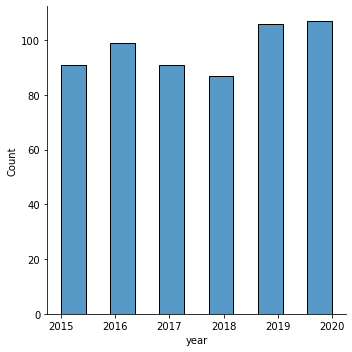

In [32]:
fg = sns.displot(df['year'])

### What is the best month to end your masters?

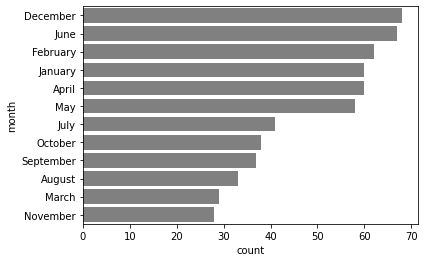

In [33]:
ax = sns.countplot(y=df['month'],
              order=df['month'].value_counts().index,
              color="gray")

### What is the best day to look for positions?

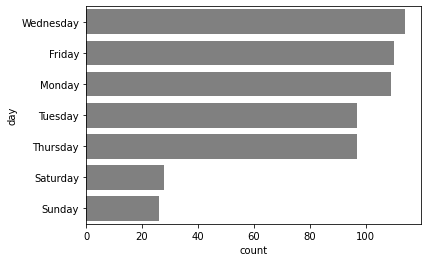

In [34]:
ax = sns.countplot(y=df['day'],
              order=df['day'].value_counts().index,
              color="gray")

### Likes and retweets

- What is their distribution and their relation?

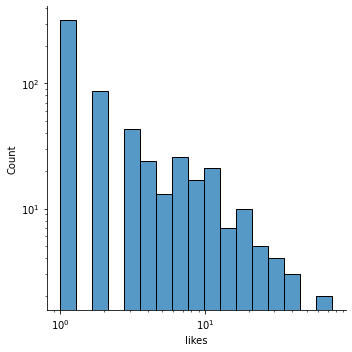

In [35]:
fg = sns.displot(df['likes'] + 1, log_scale=(True, True))

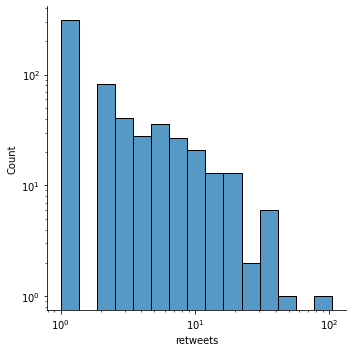

In [36]:
fg = sns.displot(df['retweets'] + 1, log_scale=(True, True))

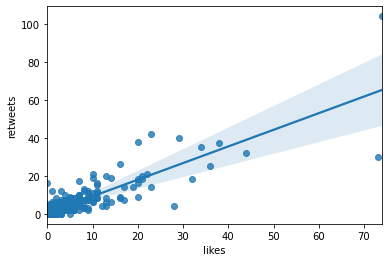

In [37]:
ax = sns.regplot(x='likes', y='retweets', data=df)

In [38]:
df.corr()

,likes,retweets,year
likes,1.000000,0.860350,0.300956
retweets,0.860350,1.000000,0.223863
year,0.300956,0.223863,1.000000


# References

- requests: https://realpython.com/python-requests/
- search tweets: https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-all 

## Beautiful Soup

In [ ]:
r = requests.get("https://ceaa.colmex.mx/profes")

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
soup = BeautifulSoup(r.text, 'html.parser')

In [ ]:
ceaa = []
for p in links:
    if p('span'):
        ceaa.append(p('span')[-1].text)